#### The following algorithm was produced in 2021 as part of an honours project through the University of Cape Town. In this paper we presented a supernovae model which makes use of Markov-Chain Monte Carlo data fitting methods to fit a light curve to possible radio supernovae sources. The algorithm below is applied to a known supernova source, SN 2004dj, which was used as a proof of concept. For the full paper please contact me at: zane19.zl@gmail.com

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
import pandas as pd
%matplotlib inline
plt.rcParams['figure.figsize'] = (9,6)

#### Load data and sort

In [28]:
df = pd.read_csv('sn2004dj_radio.csv')

In [29]:
df = df[(df['Freq']>1.3)&((df['Freq']<1.5))].reset_index(drop=True) #Obtain 1.4 GHz data
t = df['Age']
S_nu = df['Fnu']
S_nu_err = df['e_Fnu']
nu = 1.4 #1.4 GHz

#### First plot of original data of SN 2004dj in the 1.4GHz band

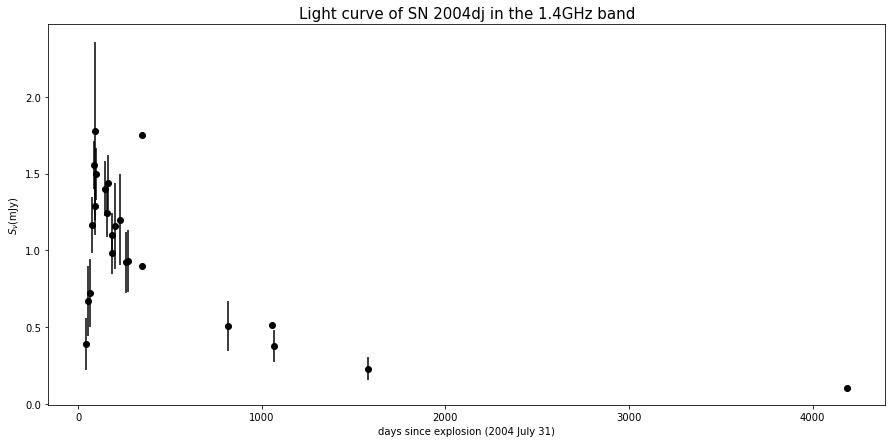

In [30]:
plt.figure(figsize=(15,7))
plt.errorbar(t,S_nu,yerr=S_nu_err,marker='o',ls='',mfc="black",mec="black",c="black")
plt.title("Light curve of SN 2004dj in the 1.4GHz band",fontsize=15)
plt.xlabel('days since explosion (2004 July 31)',fontsize=10)
plt.ylabel(r'$S_\nu$(mJy)',fontsize=10)
plt.show()

### Set up MCMC
#### MCMC code based on code from Imad Pasha (2017)
#### https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial.html

Model
$$
\begin{aligned}
S(\nu, t)&=K_{1}\left(\frac{\nu}{5 \mathrm{GHz}}\right)^{\alpha}\left(\frac{t-t_0}{1 \mathrm{day}}\right)^{\beta} e^{-\tau_{\mathrm{ffa}}} \\
\tau_{\mathrm{ffa}}&=K_{2}\left(\frac{\nu}{5 \mathrm{GHz}}\right)^{-2.1}\left(\frac{t-t_0}{1 \mathrm{day}}\right)^{\delta}
\end{aligned}
$$
where $K_1, K_2, \alpha$ and $\beta$ are the parameters we will be fitting for. NB: $\delta = -3 + \alpha - \beta$

In [31]:
def model(theta,t=t,nu=nu):
    K1,K2,alpha,beta = theta
    tau=K2*(nu/5)**(-21/10)*(t/1)**(-3+alpha-beta)
    S=K1*(nu/5)**(alpha)*(t/1)**(beta)*np.exp(-tau)
    return S

In [32]:
def lnlike(theta, x, y, yerr):
    return -0.5 * np.sum(((y - model(theta, x))/yerr) ** 2)

#### Set prior conditions (these were based on results from Weiler et at. (2002))

In [33]:
def lnprior(theta):
    K1,K2,alpha,beta = theta
    if 0 < K1<1e2  and 0.0 < K2<1e9  and -3.0 < alpha < 0 and -3.0 < beta < 0:
        return 0.0
    return -np.inf

In [34]:
def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

In [35]:
data = (t, S_nu,S_nu_err)
nwalkers = 400
niter = 2000
initial = np.array([0.8, 0.03, -0.9, -1.13])
ndim = len(initial)
p0 = [np.array(initial) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

In [36]:
def main(p0,nwalkers,niter,ndim,lnprob,data):
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=data)

    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 300)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)

    return sampler, pos, prob, state

In [37]:
sampler, pos, prob, state = main(p0,nwalkers,niter,ndim,lnprob,data)

Running burn-in...
Running production...


In [38]:
def plotter(sampler,t=t,S_nu=S_nu,nu=nu):
    plt.ion()
    plt.plot(t,S_nu,"o")
    samples = sampler.flatchain
    for theta in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(t, model(theta, t,nu), color="r", alpha=0.1)
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.title("Light curve of SN 2004dj in the 1.4GHz band",fontsize=15)
    plt.xlabel('days since explosion (2004 July 31)',fontsize=10)
    plt.ylabel(r'$S_\nu$(mJy)',fontsize=10)
    plt.ylim(0,3)
    plt.show()

#### Second Plot of itterations being plotted over original data points

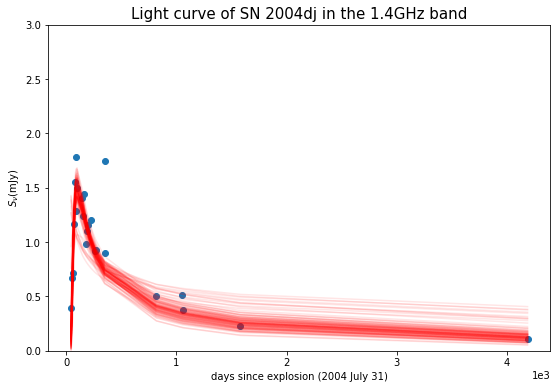

In [39]:
plotter(sampler)

In [40]:
samples = sampler.flatchain
samples[np.argmax(sampler.flatlnprobability)]

array([ 4.45736859e+01,  2.59835846e+03, -2.81900589e-01, -7.52957614e-01])

#### Third Plot of best fit plotted over original data

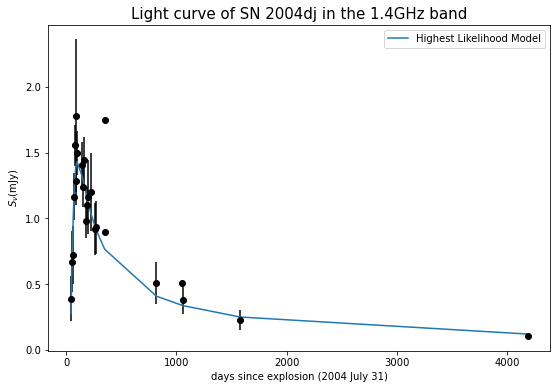

Theta max:  [ 4.45736859e+01  2.59835846e+03 -2.81900589e-01 -7.52957614e-01]


In [48]:
samples = sampler.flatchain

theta_max  = samples[np.argmax(sampler.flatlnprobability)]
best_fit_model = model(theta_max)
plt.errorbar(t,S_nu,yerr=S_nu_err,marker='o',ls='',mfc="black",mec="black",c="black")
plt.plot(t,best_fit_model,label='Highest Likelihood Model')
plt.title("Light curve of SN 2004dj in the 1.4GHz band",fontsize=15)
plt.xlabel('days since explosion (2004 July 31)',fontsize=10)
plt.ylabel(r'$S_\nu$(mJy)',fontsize=10)
plt.legend()
plt.show()
print('Theta max: ',theta_max)

#### Corner Plot with optimum values for free parameters of K1, K2, α, β along with associated errors

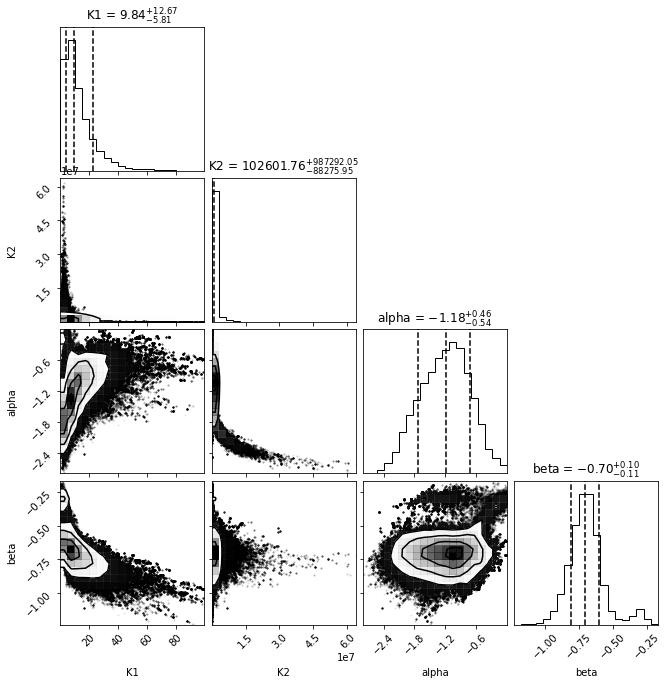

In [42]:
labels = ['K1','K2','alpha','beta']
fig = corner.corner(samples,show_titles=True,labels=labels,plot_datapoints=True,quantiles=[0.16, 0.5, 0.84])

In [43]:
def sample_walkers(nsamples,flattened_chain):
    models = []
    draw = np.floor(np.random.uniform(0,len(flattened_chain),size=nsamples)).astype(int)
    thetas = flattened_chain[draw]
    for i in thetas:
        mod = model(i)
        models.append(mod)
    spread = np.std(models,axis=0)
    med_model = np.median(models,axis=0)
    return med_model,spread
med_model, spread = sample_walkers(100,samples)

#### Fourth Plot of best fit model and posterior spread plotted over original data with associated error values

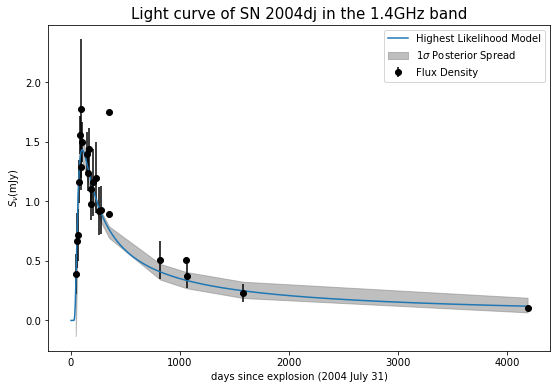

In [46]:
plt.errorbar(t,S_nu,yerr=S_nu_err,marker='o',ls='',mfc="black",mec="black",c="black",label="Flux Density")
K1,K2,alpha,beta=theta_max
day=np.arange(1,np.max(t))
tau=K2*(nu/5)**(-21/10)*(day/1)**(-3+alpha-beta)
S=K1*(nu/5)**(alpha)*(day/1)**(beta)*np.exp(-tau)
plt.plot(day,S,label="Highest Likelihood Model")
plt.fill_between(t,med_model-spread,med_model+spread,color='grey',alpha=0.5,label=r'$1\sigma$ Posterior Spread')
plt.title("Light curve of SN 2004dj in the 1.4GHz band",fontsize=15)
plt.xlabel('days since explosion (2004 July 31)',fontsize=10)
plt.ylabel(r'$S_\nu$(mJy)',fontsize=10)
plt.legend()
plt.show()